<a href="https://colab.research.google.com/github/serg-kas/A-G-I-demo/blob/master/A_G_I_CNN_model_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analog Gauge Inspection

**Создание и обучение модели определения показания стрелочного прибора.**

In [1]:
!git clone https://github.com/serg-kas/A-G-I-demo
%cd A-G-I-demo

Cloning into 'A-G-I-demo'...
remote: Enumerating objects: 93, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 93 (delta 49), reused 48 (delta 19), pack-reused 0
Unpacking objects: 100% (93/93), done.
/content/A-G-I-demo


In [79]:
# Импорт библиотек
import numpy as np
import cv2 as cv
import os
#
import utils as u 

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D
from tensorflow.keras.layers import Reshape, GlobalAveragePooling2D, UpSampling2D, AveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.callbacks import ReduceLROnPlateau, EarlyStopping 
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import load_model, save_model

from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
%matplotlib inline

Случайное показание прибора: 27
Размер картинки для обучения: (87, 255, 3)


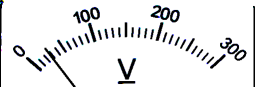

In [66]:
    # Подготовим изображение прибора (резайз и пр.)
    u.gauge_img_preparing()
    assert 'Voltmeter-Blank.jpg' in os.listdir('.')

    # Загружаем изображение прибора без стрелки
    img = cv.imread('Voltmeter-Blank.jpg')
    # Подготавливаем данные положения стрелки прибора
    # L - длинна стрелки
    # angle_0, angle_1  - углы крайних положений стрелки
    L, angle_0, angle_1 = u.gauge_needle_preparing(img)

    # Получаем случайное показание прибора
    img_example, r = u.get_random_measurement(img, L, angle_0, angle_1)
    print('Случайное показание прибора: {}'.format(int(300 * (1 - r))))
    print('Размер картинки для обучения: {}'.format(img_example.shape))

    cv2_imshow(img_example)

In [116]:
# Функция  - генератор данных
def generate_data(batchsize):
    x_data = []
    y_data = []
    batchcount = 0
    while True:
        curr_img, curr_r = u.get_random_measurement(img, L, angle_0, angle_1)
        curr_img = cv.resize(curr_img, (256, 256), interpolation=cv.INTER_AREA)
        curr_img = curr_img / 255.
        # curr_r = curr_r - 1
        x_data.append(curr_img)
        y_data.append(curr_r)
        batchcount += 1
        if batchcount >= batchsize:
            X = np.array(x_data, dtype='float32')
            y = np.array(y_data, dtype='float32')
            # print(X.shape, y.shape)
            yield (X, y)
            x_data = []
            y_data = []
            batchcount = 0


In [95]:
# Функция создания модели
def get_model(img_height, img_width):
  model = Sequential()
  #Первый сверточный слой
  model.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(img_height, img_width, 3)))
  model.add(BatchNormalization())

  # Второй сверточный слой
  model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(3, 3)))
  model.add(Dropout(0.2))

  # Третий сверточный слой
  model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  #model.add(Dropout(0.2))   

  # Четвертый сверточный слой
  model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(3, 3)))
  model.add(Dropout(0.2)) 

  # Пятый сверточный слой
  model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
  #model.add(Dropout(0.2))
  model.add(BatchNormalization())

  # Шестой сверточный слой
  model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))

  # Слой регуляризации Dropout
  model.add(Dropout(0.2))  

  # Слой преобразования двумерных данных в одномерные 
  model.add(Flatten())
  # Полносвязный слой
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.2))

  # Полносвязный слой
  model.add(Dense(512, activation='relu'))  
  model.add(Dropout(0.2))

  # Выходной слой
  model.add(Dense(1, activation='linear'))
 
  # model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])
  model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mae'])

  return model


In [117]:
# Функция создания модели
def get_model(img_height, img_width):
    input_shape = (img_height, img_width, 3)
    img_input = Input(input_shape)                                         # Создаем входной слой с размерностью input_shape

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input) # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)         # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_1_out

    x = MaxPooling2D()(block_1_out)                                        # Добавляем слой MaxPooling2D

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)        # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)        # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_2_out

    x = MaxPooling2D()(block_2_out)                                        # Добавляем слой MaxPooling2D

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_3_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_3_out

    x = MaxPooling2D()(block_3_out)                                        # Добавляем слой MaxPooling2D

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)        # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_4_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_4_out
    x = block_4_out 

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)    # Добавляем слой Conv2DTranspose с 256 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = concatenate([x, block_3_out])                                      # Объединем текущий слой со слоем block_3_out
    x = Conv2D(256, (3, 3), padding='same')(x)                             # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)    # Добавляем слой Conv2DTranspose с 128 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = concatenate([x, block_2_out])                                      # Объединем текущий слой со слоем block_2_out
    x = Conv2D(128, (3, 3), padding='same')(x)                             # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same')(x)                             # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)     # Добавляем слой Conv2DTranspose с 64 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = concatenate([x, block_1_out])                                      # Объединем текущий слой со слоем block_1_out
    x = Conv2D(64, (3, 3), padding='same')(x)                              # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x)                              # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)          # 

    model = Model(img_input, x) # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель 
    model.compile(loss='mae', optimizer=Adam(learning_rate=0.001), metrics=['mae'])
    
    return model   

In [118]:
    # Создаем модель
    # model = get_model(img_example.shape[0], img_example.shape[1])
    model = get_model(256, 256)
    # Напечатаем архитектуру
    model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_12[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_267 (Batch  (None, 256, 256, 64  256        ['block1_conv1[0][0]']           
 Normalization)                 )                                                          

In [119]:
# Запускаем обучение
batch_size = 10
history = model.fit(generate_data(batch_size),steps_per_epoch= 1000/batch_size, epochs=10)

Epoch 1/10
100/100 [==============================] - 60s 578ms/step - loss: 0.2576 - mae: 0.2576
Epoch 2/10
  6/100 [>.............................] - ETA: 53s - loss: 0.2426 - mae: 0.2426

KeyboardInterrupt: ignored

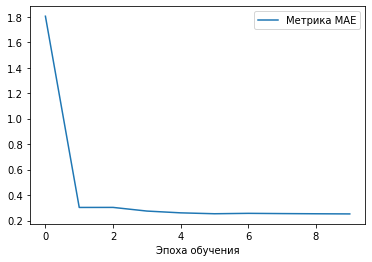

In [71]:
# График точности обучения
plt.plot(history.history['mae'], label='Метрика MAE')
plt.xlabel('Эпоха обучения')
plt.legend()
plt.show()

In [72]:
# Сохраняем модель
model.save('base-model-CNN.h5')
!ls

A_G_I_CNN_model_train.ipynb  model-CNN.h5  Voltmeter-Blank.jpg
best-1-model-CNN.h5	     __pycache__   Voltmeter-NoNeedle.jpg
best-2-model-CNN.h5	     README.md	   Voltmeter-Original.jpg
main.py			     utils.py


In [73]:
# Дообучаем
model = load_model('base-model-CNN.h5')

lr = 0.001
history_list = []

# Определим коллбэки
reduce_lr = ReduceLROnPlateau(monitor='mae', 
                              patience=3, 
                              verbose=1, 
                              factor=0.5, 
                              min_lr=0.00001)
earlystopper = EarlyStopping(patience=15,
                             verbose=1,
                             monitor='mae',
                             restore_best_weights=True)

for N in range(1,3):

  model.compile(loss='mse', optimizer=Adam(learning_rate=lr), metrics=['mae'])


  print('\nТренировка: ', 'Best -', N)

  batch_size = 10
  history = model.fit(generate_data(batch_size),
                      steps_per_epoch= 1000/batch_size,
                      epochs=300,
                      verbose=1,
                      callbacks=[reduce_lr,earlystopper])

  history_list.append(history)
  
  model.save('best-' + str(N) + '-' + 'model-CNN.h5' )



Тренировка:  Best - 1
Epoch 1/300
100/100 [==============================] - 5s 42ms/step - loss: 2.1119 - mae: 0.6884 - lr: 0.0010
Epoch 2/300
100/100 [==============================] - 4s 40ms/step - loss: 0.0890 - mae: 0.2582 - lr: 0.0010
Epoch 3/300
100/100 [==============================] - 4s 40ms/step - loss: 0.0904 - mae: 0.2567 - lr: 0.0010
Epoch 4/300
100/100 [==============================] - 4s 40ms/step - loss: 0.0884 - mae: 0.2582 - lr: 0.0010
Epoch 5/300
100/100 [==============================] - 4s 40ms/step - loss: 0.0823 - mae: 0.2469 - lr: 0.0010
Epoch 6/300
100/100 [==============================] - 4s 40ms/step - loss: 0.0855 - mae: 0.2496 - lr: 0.0010
Epoch 7/300
100/100 [==============================] - 4s 40ms/step - loss: 0.0945 - mae: 0.2600 - lr: 0.0010
Epoch 8/300
100/100 [==============================] - 4s 40ms/step - loss: 0.0812 - mae: 0.2449 - lr: 0.0010
Epoch 9/300
100/100 [==============================] - 4s 40ms/step - loss: 0.0841 - mae: 0.2500 

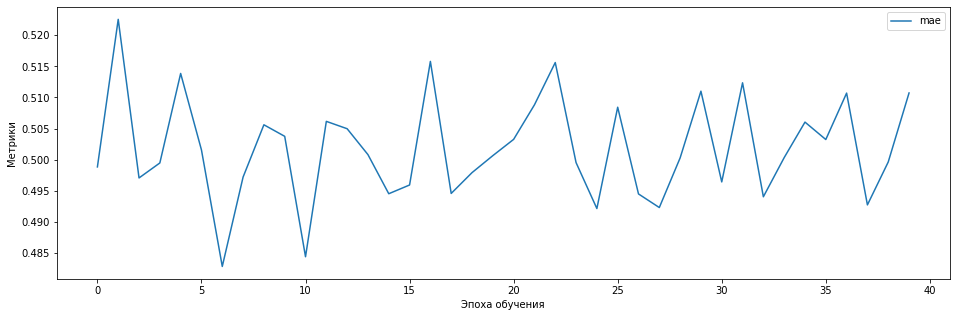

In [63]:
#Отображаем график точности в процессе обучения
history_mae = []
for N in range(2):
  history_mae += history_list[N].history['mae']

plt.figure(figsize=(16,5))
plt.plot(history_mae, 
         label='mae')
plt.xlabel('Эпоха обучения')
plt.ylabel('Метрики')
plt.legend()
plt.show()

**Посмотрим предикт**

In [64]:
# model = load_model('base-model-CNN.h5')
img = cv.imread('Voltmeter-Blank.jpg')
L, angle_0, angle_1 = u.gauge_needle_preparing(img)

N = 10
# fig, axs = plt.subplots(1, N, figsize=(18, 5))
for i in range(N):
  curr_img, curr_r = u.get_random_measurement(img, L, angle_0, angle_1)
  # подготовим изображение для отправки в модель
  img_to_pred = np.array(curr_img)
  img_to_pred = img_to_pred / 255. 
  img_to_pred = np.expand_dims(img_to_pred, axis = 0)
  pred = model.predict(img_to_pred)[0]
  print("Значение: {:.2f}, предикт {:.2f}".format(curr_r, pred[0]))
  


Значение: 0.03, предикт 0.00
Значение: 0.15, предикт 0.00
Значение: 0.88, предикт 0.00
Значение: 0.29, предикт 0.00
Значение: 0.14, предикт 0.00
Значение: 0.21, предикт 0.00
Значение: 0.05, предикт 0.00
Значение: 0.41, предикт 0.00
Значение: 0.98, предикт 0.00
Значение: 0.77, предикт 0.00
